# 04. PyTorch Custom Datasets

We've used some datasets with PyTorch before.

But how do we `get our own data` into PyTorch?

One of the ways to do so is via `Custom Datasets`

We are going to build `FoodVision Mini` in this chapter.

## What we're going to cover

1. Getting a `custom dataset` with PyTorch
2. `Becoming one with the data` - preparing and visualizing
3. `Transforming data` for use with a model
4. `Loading custom data` with pre-built functions and custom functions
5. Building `FoodVision Mini` to classify food images.
6. Comparing models with and without `data augmentation`
7. `Making predictions` on custom data.

## 0. Importing PyTorch and setting up device agnostic code

In [7]:
import torch
from torch import nn


device = 'gpu' if torch.cuda.is_available() else 'cpu'

print('PyTorch version: ', torch.__version__)
print('Available device: ', device)

PyTorch version:  2.0.1
Available device:  cpu


## 1. Get data

Our dataset is a subset of the `Food101 dataset`.

Food101 dataset has 101 different classes of food with 1000 images per class(750 training, 250 testing)

`Our dataset` stars with `3 classes of food` and only `10% of the images(~75 training, 25 testing)`

`Why do this?`

When `starting` out ML projects, it's important to try things on a `small` scale and then `increase` the scale `when necessary`.

`The whole point is to spped up the experiment`

In [9]:
import requests
import zipfile
from pathlib import Path

# setup path to a data folder
data_path = Path('data/')
image_path = data_path / 'pizza_steak_sushi'

# if image folder doesn't exist, download and prepare it
if image_path.is_dir():
    print(f'{image_path} directory already exists. Skipping download')
else:
    print(f'{image_path} does not exist, creating one...')
    image_path.mkdir(parents=True, exist_ok=True)

# Download the data
data_url = 'https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip'
data_file_name = data_url.split('/')[-1]
download_file_path = data_path / data_file_name # 'pizza_steak_sushi.zip'

with open(download_file_path, 'wb') as f:
    request = requests.get(data_url)
    print("Downloading pizza, steak, sushi data...")
    f.write(request.content)

# Unzip pizza, steak, sushi data
with zipfile.ZipFile(download_file_path, 'r') as zip_ref:
    print('Unzipping the data')
    zip_ref.extractall(image_path)

data/pizza_steak_sushi does not exist, creating one...
Unzipping the data


In [32]:
train_dir = image_path / 'train'
test_dir = image_path / 'test'

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

In [27]:
Path(glob.glob(f'{str(train_dir)}/*/*')[0]).parent.stem

'steak'

### 2.1 Visualizing the image

1. Get all of the images paths
2. pick random image path using Python's random.choice()
3. Get the image class name using `pathlib.path.parent.stem`
4. Open the image with Python's PIL
5. Show the image and print metadata.

300
data/pizza_steak_sushi/test/sushi/2276986.jpg
Random Image path: data/pizza_steak_sushi/test/sushi/2276986.jpg
Image class: sushi
Image height: 512
Image width: 512


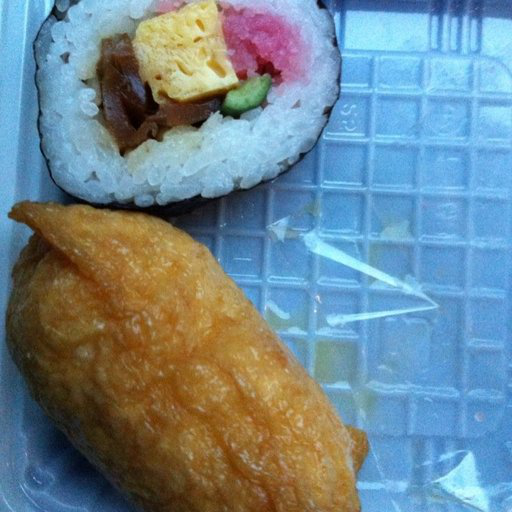

In [64]:
import random
from PIL import Image
from IPython import display

# set seed
# random.seed(42)

# 1. Get all the images paths
image_path_list = list(image_path.glob('*/*/*.jpg'))
print(len(image_path_list))

# 2. pick a random image path

random_image_path = random.choice(image_path_list)
print(random_image_path)

# 3. Get image class from path name
image_class = random_image_path.parent.stem
image_class

# 4. Open Image
img = Image.open(random_image_path)

# # 5. Print metadata
print(f'Random Image path: {random_image_path}')
print(f'Image class: {image_class}')
print(f'Image height: {img.height}')
print(f'Image width: {img.width}')
img

### 2.2 Visualizing with Matplotlib

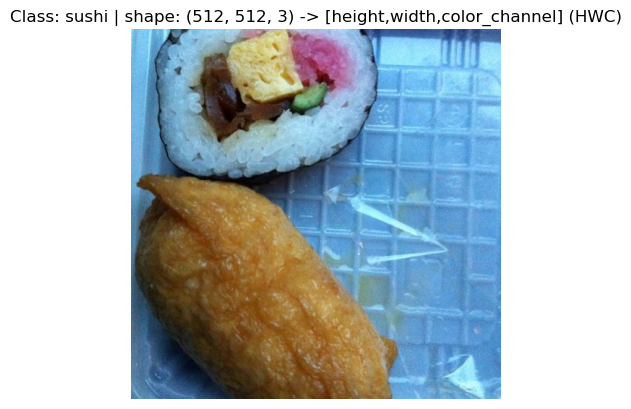

In [73]:
import numpy as np
import matplotlib.pyplot as plt

# turn the image into array
images_as_array = np.asarray(img)

# plt.figure(figsize=(10,7))
plt.imshow(images_as_array);
plt.title(f'Class: {image_class} | shape: {images_as_array.shape} -> [height,width,color_channel] (HWC)')
plt.axis(False);

In [74]:
images_as_array

array([[[149, 229, 254],
        [145, 225, 250],
        [129, 206, 234],
        ...,
        [ 60,  94, 155],
        [ 65,  99, 160],
        [ 65,  97, 158]],

       [[152, 232, 255],
        [148, 225, 251],
        [138, 215, 243],
        ...,
        [ 63,  98, 156],
        [ 69, 101, 162],
        [ 66,  98, 159]],

       [[151, 228, 254],
        [143, 220, 246],
        [142, 217, 246],
        ...,
        [ 64,  96, 155],
        [ 67,  99, 158],
        [ 62,  94, 153]],

       ...,

       [[ 66, 119, 153],
        [ 75, 128, 162],
        [ 77, 130, 164],
        ...,
        [139, 190, 235],
        [138, 189, 234],
        [158, 209, 254]],

       [[ 74, 124, 159],
        [ 80, 130, 165],
        [ 81, 131, 166],
        ...,
        [148, 199, 244],
        [157, 208, 251],
        [161, 210, 253]],

       [[ 82, 132, 167],
        [ 86, 134, 170],
        [ 85, 133, 169],
        ...,
        [151, 200, 243],
        [168, 217, 255],
        [150, 199, 242]]